In [19]:
from sklearn.model_selection import train_test_split
from thundersvm import SVC, NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
import bhtsne
from scipy.spatial.distance import pdist
from itertools import *
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from IPython.display import display
from scipy import sparse as sp
import scipy
from sklearn.metrics import *
from sklearn.preprocessing import *
from tqdm import tqdm, tqdm_pandas, tqdm_notebook, tqdm_gui
import os
import time
import random
import math
import igraph as ig
import networkx as nx
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

In [20]:
def NX_to_IG(G, directed=False):
    return ig.Graph(len(G),
                    list(zip(*list(zip(*nx.to_edgelist(G)))[:2])),
                    directed=directed)


def to_frame(x):
    test = pd.DataFrame(
        x, columns=['Emb_{}'.format(i) for i in range(x.shape[1])])
    test['nodes'] = G.nodes()
    return test


from sklearn.manifold import TSNE


def plot_embedding(emb, label, name):

    embeddings = emb[[
        fea for fea in emb.columns if fea not in ['label', 'nodes']
    ]].values
    X, Y = label['nodes'].values, label['label'].values
    fig = plt.figure(figsize=(8, 5))
    plt.title('{} DataSet'.format(name))

    emb_list = []

    for k in X:
        emb_list.append(embeddings[k])

    emb_list = np.array(emb_list)
    node_pos = bhtsne.tsne(embeddings.astype(np.float64))
    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)

    alpha = 0.6
    for c, idx in color_idx.items():
        plt.scatter(
            node_pos[idx, 0],
            node_pos[idx, 1],
            label=c,
            cmap='jet',
            alpha=alpha,
            marker='o',
            edgecolor='black',
            linewidths=1,
        )

    plt.legend()
    plt.show()


def get_cv_score(emb, G, G_label, clf, name):
    ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
    tot = 0
    for i in clf:  # svc_linear,svc_rbf,
        k, k1 = [], []
        print(i)
        for test_size in tqdm_notebook(ratios):
            train, test, train_label, test_label = train_test_split(
                emb,
                G_label['label'].map(lambda x: x[0]).values,
                test_size=1 - test_size)
            try:
                scores_clf = cross_validate(i,
                                            train,
                                            train_label,
                                            cv=10,
                                            scoring=['f1_micro', 'f1_macro'],
                                            n_jobs=-1,
                                            verbose=0)
            except:
                scores_clf = cross_validate(i,
                                            train,
                                            train_label,
                                            cv=10,
                                            scoring=['f1_micro', 'f1_macro'],
                                            n_jobs=1,
                                            verbose=0)
            micro = "%0.4f±%0.4f" % (scores_clf['test_f1_micro'].mean(),
                                     scores_clf['test_f1_micro'].std() * 2)
            macro = "%0.4f±%0.4f" % (scores_clf['test_f1_macro'].mean(),
                                     scores_clf['test_f1_macro'].std() * 2)
            k.append([micro, macro])
            i.fit(train.astype(np.float32), train_label.astype(np.float32))
            k1.append([
                f1_score(test_label, i.predict(test.astype(np.float32)), average='micro'),
                f1_score(test_label, i.predict(test.astype(np.float32)), average='macro')
            ])

        tr = pd.DataFrame(k).T
        tr.columns = ['ratio {}'.format(i) for i in ratios]
        tr.index = ['train-micro', 'train-macro']

        display(tr)

    return tr


def read_data(name):
    G = nx.read_adjlist("./input/{}/{}_adjlist.txt".format(name, name),
                        delimiter=' ',
                        nodetype=int,
                        create_using=nx.DiGraph())
    G.add_edges_from([i[::-1] for i in list(G.edges())])  # 显式的加入双向边
    G_label = pd.read_pickle("./input/{}/{}_label.pickle".format(name, name))
    G_attr = pd.read_pickle("./input/{}/{}_attr.pickle".format(name, name))
    G_label['label'] = G_label['label'].map(lambda x: [x])

    iG = NX_to_IG(G, False)
    for i in tqdm_notebook(range(iG.vcount())):
        G.add_edge(i, i)

    print("{} Have {} Nodes, {} Edges, {} Attribute, {} Classes".format(
        name, iG.vcount(), iG.ecount(), G_attr.shape[1] - 1,
        G_label['label'].astype('str').nunique()))

    return iG, G, G_label, G_attr

In [21]:
import tensorflow as tf
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
from keras.models import *
from keras.callbacks import *
from keras.initializers import he_uniform, glorot_uniform, lecun_uniform
from keras.utils import to_categorical
from keras import backend as K
from keras import *
from keras.activations import *
from keras.utils import plot_model, multi_gpu_model, model_to_dot
from IPython.display import SVG
from keras_tqdm import TQDMNotebookCallback, TQDMCallback


class PairEmbedding(object):
    def __init__(self,
                 G,
                 attribute,
                 G_label,
                 embedding_size,
                 epochs,
                 silent=False):
        super(PairEmbedding, self).__init__() 
        self.G = G
        self.G_label = G_label
        self.embedding_size = embedding_size
        self.epochs = epochs
        self.silent = silent

        W = attribute.drop('nodes', axis=1).fillna(0).values
        attribute = W / np.linalg.norm(W, axis=1, keepdims=True)
        self.attribute = pd.DataFrame(
            attribute,
            columns=[
                "attribute_{}".format(i) for i in range(attribute.shape[1])
            ]).fillna(0)
        self.nodes_embedding = pd.DataFrame(
            np.random.rand(len(self.G.nodes()), self.embedding_size),
            columns=["embedding_{}".format(i) for i in range(embedding_size)])

    def MultiTask_SelfsSupervision_AE(self, AggAttribute, SelfAttribute):

        input_1 = Input(shape=(AggAttribute, ))
        x_1 = Dense(self.embedding_size * 4)(input_1)
        output_1 = Dense(self.embedding_size,
                         name="Agg_Attribute_Encoder")(x_1)

        input_2 = Input(shape=(SelfAttribute, ))
        x_2 = Dense(self.embedding_size * 4)(input_2)
        output_2 = Dense(self.embedding_size,
                         name='Self_Attribute_Encoder')(x_2)

        conv = concatenate([
            x_1,
            x_2,
            output_1,
            output_2,
        ])
        conv = BatchNormalization()(conv)
        conv = Dense(self.embedding_size, name='pair_embedding')(conv)

        neighbor_A = Dense(AggAttribute,
                           activation='softmax',
                           name='Neibor_Attribute')(conv)
        self_A = Dense(SelfAttribute,
                       activation='softmax',
                       name='Self_Attribute')(conv)

        model = Model(inputs=[input_1, input_2], outputs=[neighbor_A, self_A])

        return model

    def model(self, AggAttribute, SelfAttribute, lr):
        K.clear_session()
        model = self.MultiTask_SelfsSupervision_AE(
            AggAttribute.shape[1],
            SelfAttribute.shape[1],
        )

        model.compile(optimizer=Adam(lr=lr),
                      loss={
                          'Neibor_Attribute': 'kullback_leibler_divergence',
                          'Self_Attribute': 'kullback_leibler_divergence',
                      },
                      metrics={
                          'Neibor_Attribute': 'kullback_leibler_divergence',
                          'Self_Attribute': 'kullback_leibler_divergence',
                      },
                      loss_weights={
                          'Neibor_Attribute': 1,
                          'Self_Attribute': 1,
                      })
        tf_input = [
            StandardScaler().fit_transform(AggAttribute),
            StandardScaler().fit_transform(SelfAttribute),
        ]
        tf_output = [
            AggAttribute,
            SelfAttribute,
        ]
        callbacks = [ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
        
        if not self.silent:
            callbacks.append(TQDMNotebookCallback(leave_inner=False,leave_outer=True))
        model.fit(tf_input,
                  tf_output,
                  epochs=self.epochs,
                  batch_size=1024,
                  shuffle=True,
                  verbose=0,
                  callbacks=callbacks)
        plot_model(model)
        embed = Model(inputs=model.input,
                      outputs=model.get_layer('pair_embedding').output)

        embedding = embed.predict(tf_input, batch_size=2048, verbose=0)

        return embedding, model

    def AggGraph(self, edges, to_agg, agg_func=['mean', 'sum']):
        edges = edges.merge(to_agg.add_prefix("u_").reset_index().rename(columns={'index' : 'u'}),how='left',on='u').\
                      merge(to_agg.add_prefix("v_").reset_index().rename(columns={'index' : 'v'}),how='left',on='v')
        u_col, v_col = [i for i in edges.columns
                        if 'u_' in i], [i for i in edges.columns if 'v_' in i]
        cross = edges[['u'] + v_col].groupby(['u'])[v_col].agg(agg_func).values

        attention_0, attention_1 = [], []
        u_values, v_values = edges[u_col].values, edges[v_col].values
        for i in range(len(edges)):
            attention_0.append(pdist([u_values[i], v_values[i]], 'cosine')[0])

        edges['cosine'] = attention_0
        attention = edges[['u', 'cosine'
                           ]].groupby(['u'])[['cosine']].agg(agg_func).values

        df = pd.DataFrame(np.hstack((cross, attention)))
        df.fillna(0, inplace=True)
        df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

        uv = edges[['u', 'v']]
        uv = uv.merge(df.reset_index().rename(columns={"index" : "u"}),how='left',on='u').\
                merge(df.reset_index().rename(columns={"index" : "v"}),how='left',on='v')
        uv['cosine'] = attention_0
        uv.fillna(0, inplace=True)
        uv.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

        return uv.values

    def SelfGraph(self, edges, to_calc):
        edges = edges.merge(to_calc.add_prefix("u_").reset_index().rename(columns={'index' : 'u'}),how='left',on='u').\
                      merge(to_calc.add_prefix("v_").reset_index().rename(columns={'index' : 'v'}),how='left',on='v')
        return edges[[i for i in edges.columns if i not in ['u', 'v']]].values

    def fit(self):

        lr = 0.001

        edges = pd.DataFrame(self.G.edges(), columns=['u', 'v'])
        AggAttribute = self.AggGraph(edges, self.attribute, [
            'mean',
        ])
        SelfAttribute = self.SelfGraph(edges, self.attribute)
        ne, cpc = self.model(AggAttribute, SelfAttribute, lr)
        pairs_embedding = pd.DataFrame(
            ne, columns=["{}_pair".format(i) for i in range(ne.shape[1])])
        pairs_col = list(pairs_embedding.columns)
        edges[pairs_col] = pairs_embedding
        self.edges_embedding = edges[['u','v'] + pairs_col]
        u, v = edges[['u'] + pairs_col].rename(
            columns={'u': 'nodes'}), edges[['v'] + pairs_col].rename(
                columns={'v': 'nodes'})
        edges = pd.concat([u, v], axis=0, ignore_index=True)
        edges = edges.groupby(['nodes'])[pairs_col].agg(['sum'
                                                         ]).sort_index().values
        edges = edges / np.linalg.norm(edges, axis=1, keepdims=True)
        self.nodes_embedding = pd.DataFrame(
            edges,
            columns=["embedding_{}".format(i) for i in range(edges.shape[1])])
        return self.nodes_embedding, self.edges_embedding, cpc

    def evaluate(self, clf=[LogisticRegression(n_jobs=-1)]):
        now = self.nodes_embedding.copy()

        get_cv_score(
            now.values, self.G, self.G_label, clf, "{} {}".format(
                'Pair Embedding',
                "Dimensions={} Node Embedding Visualization".format(
                    self.embedding_size)))

In [22]:
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Multi Task Self-Supervied Auto Encoder Model

### Read Data

In [23]:
dataset = 'cora'
iG,G,G_label,G_attr = read_data(dataset)
num_classes = G_label['label'].map(lambda x:x[0]).nunique()


cora Have 2708 Nodes, 10556 Edges, 1433 Attribute, 7 Classes


In [24]:
model = PairEmbedding(G,G_attr,G_label,embedding_size=128,epochs=30,silent=False)
node_embedding, edge_embedding, MultiTask_SelfSupervision_AE = model.fit()

### Train Model

## Downstream tasks
### Node classification

#### Unsupervised evaluation method
Divide the training set test set according to the ratio of [0.1, 0.3, 0.5, 0.7, 0.9]<br>
And use our pre-defined classifier to perform 10-fold cross-validation on the divided set

In [26]:
model.evaluate(clf=[LogisticRegression(n_jobs=-1)])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


,ratio 0.1,ratio 0.3,ratio 0.5,ratio 0.7,ratio 0.9
train-micro,0.8407±0.0997,0.8522±0.0832,0.8685±0.0607,0.8686±0.0492,0.8802±0.0305
train-macro,0.7530±0.2281,0.8212±0.0990,0.8568±0.0586,0.8531±0.0554,0.8672±0.0388


### Node Clustering
Use `Normalized Mutual Info score` & `Adjusted Rand Score` <br>
Use the permutation technique to calculate all possible mapping functions <br>
Ex: (0,1,2,3,4,5,6) have Permutation( (0,1,2,3,4,5,6) ) possible <br>

In [28]:
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score,adjusted_rand_score

label = G_label.copy()
label['label'] = label['label'].map(lambda x:x[0])

cluster_emb = node_embedding.copy()
cluster_emb['nodes'] = range(len(cluster_emb))
cluster_emb = cluster_emb.merge(label,how='left',on='nodes')
cluster_label = cluster_emb[['nodes','label']]
cluster_emb = cluster_emb.sort_values(by=['nodes']).drop(['nodes','label'],axis=1).values
clf = KMeans(n_clusters=num_classes,n_init=20,n_jobs=-1,)
clf.fit(cluster_emb)
cluster_label['pred'] = clf.labels_

ori_label = list(range(num_classes))
max_score = {
    'acc' : [],
    'nmi' : [],
    'ars' : [],
}

def calc_cluster(i):
    dic = pd.DataFrame()
    dic['pred'] = ori_label
    dic['label'] = i
    dic = dict(dic.values)
    now = cluster_label['pred'].replace(dic).values
    return accuracy_score(lb,now), normalized_mutual_info_score(lb,now), adjusted_rand_score(lb,now)

p = [i for i in list(permutations(ori_label)) if i not in [ori_label]] 
lb = cluster_label['label'].values
res = Parallel(n_jobs=10,backend='loky',batch_size=256)(delayed(calc_cluster)(x) for x in tqdm_notebook(p))
for r in res:
    max_score['acc'].append(r[0])
    max_score['nmi'].append(r[1])
    max_score['ars'].append(r[2])
    
print("NMI {} \nARS {}\nACC {}".format(np.max(max_score['nmi']),
                                       np.max(max_score['ars']),
                                       np.max(max_score['acc'])))



NMI 0.5605491053232909 
ARS 0.5005318986445647
ACC 0.7079025110782866


### Node visualization

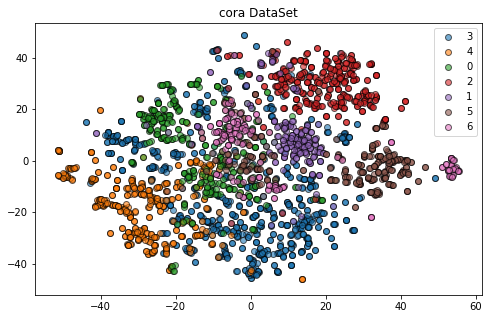

In [18]:
plot_embedding(node_embedding, G_label, dataset)